## LSM data collection

In [8]:
import glob
# set(range(5000)) - set([int(e.split('_')[-1].strip('.npy')) for e in glob.glob('data_lsm/lsm_out_5k_*.npy')])
filenames = glob.glob('data_lsm/lsm_out_5k_*.npy')
len(filenames)

2413

In [3]:
import numpy as np

lsm_out = np.array([np.load(filename) for filename in filenames])
lsm_out.shape

(1765, 1536)

21.99735931598206

In [110]:
import numpy as np
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.proc.io.source import RingBuffer as InputRingBuffer
from lava.proc.io.sink import RingBuffer as OutputRingBuffer


def forward_lsm(inp_data):
    """Forward pass of LSM.
    
    Input: inp_data (n_neurons, n_steps)
    Output: spike rates of LSM (n_neurons,)
    """
    n_neurons = inp_data.shape[0]
    n_steps = inp_data.shape[1]
    win_sparsity = 0.95
    w_sparsity = 0.99
    win_max = 0.5
    w_max = 0.05

    win = np.random.rand(n_neurons, n_neurons) * win_max
    win[np.random.rand(n_neurons, n_neurons) < win_sparsity] = 0.
    w = np.random.rand(n_neurons, n_neurons) * w_max
    w[np.random.rand(n_neurons, n_neurons) < w_sparsity] = 0.

    source = InputRingBuffer(data=inp_data)
    lsm = LIF(shape=(n_neurons,), vth=5., dv=0.1, du=0.1, bias_mant=0.)
    win_dense = Dense(weights=win)
    w_dense = Dense(weights=w)
    sink = OutputRingBuffer(shape=(n_neurons,), buffer=n_steps)

    source.s_out.connect(win_dense.s_in)
    win_dense.a_out.connect(lsm.a_in)
    lsm.s_out.connect(w_dense.s_in)
    w_dense.a_out.connect(lsm.a_in)
    lsm.s_out.connect(sink.a_in)

    run_condition = RunSteps(num_steps=n_steps)
    run_cfg = Loihi2SimCfg(select_tag="floating_pt")
    lsm.run(condition=run_condition, run_cfg=run_cfg)
    lsm_spikes = sink.data.get()
    return lsm_spikes.sum(axis=1)

In [114]:
data = np.load('data_lsm/data_5k.npy')
label = np.load('data_lsm/label_5k.npy')
trial = np.load('data_lsm/trial_5k.npy')

In [132]:
import time

def forward_lsm_mp(mp_idx):
    t_start = time.time()
    sub_data = data[mp_idx*1000:(mp_idx+1)*1000]
    for raw_idx, sample in enumerate(sub_data):
        idx = raw_idx + mp_idx*1000
        inp_data = sample.reshape(100, -1).T
        s_out = forward_lsm(inp_data)
        np.save(f'data_lsm/lsm_out_5k_{idx}.npy', s_out)
        dur = time.time() - t_start
        if idx % 100 == 99 or raw_idx < 2:
            print(f'{mp_idx}-{idx+1:04} {dur:6.1f}s {s_out.mean():6.2f} +- {s_out.std():6.2f}')

In [1]:
import multiprocessing

processes = [multiprocessing.Process(target=forward_lsm_mp, args=[arg]) for arg in range(5)]
for process in processes:
    process.start()
for process in processes:
    process.join()

NameError: name 'forward_lsm_mp' is not defined

## lsm

In [3]:
from bcdataset import BinCytometryDataset

df = '../data/bin_1ms_comp_ds'
ds = BinCytometryDataset(data_folder=df, train=True, test_fi=1, timestep_us=10, seed=42)

In [ ]:
import numpy as np
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.proc.io.source import RingBuffer as InputRingBuffer
from lava.proc.io.sink import RingBuffer as OutputRingBuffer


def forward_lsm(inp_data):
    """Forward pass of LSM.
    
    Input: inp_data (n_neurons, n_steps)
    Output: spike rates of LSM (n_neurons,)
    """
    n_neurons = inp_data.shape[0]
    n_steps = inp_data.shape[1]
    win_sparsity = 0.95
    w_sparsity = 0.99
    win_max = 0.5
    w_max = 0.05

    win = np.random.rand(n_neurons, n_neurons) * win_max
    win[np.random.rand(n_neurons, n_neurons) < win_sparsity] = 0.
    w = np.random.rand(n_neurons, n_neurons) * w_max
    w[np.random.rand(n_neurons, n_neurons) < w_sparsity] = 0.

    source = InputRingBuffer(data=inp_data)
    lsm = LIF(shape=(n_neurons,), vth=5., dv=0.1, du=0.1, bias_mant=0.)
    win_dense = Dense(weights=win)
    w_dense = Dense(weights=w)
    sink = OutputRingBuffer(shape=(n_neurons,), buffer=n_steps)

    source.s_out.connect(win_dense.s_in)
    win_dense.a_out.connect(lsm.a_in)
    lsm.s_out.connect(w_dense.s_in)
    w_dense.a_out.connect(lsm.a_in)
    lsm.s_out.connect(sink.a_in)

    run_condition = RunSteps(num_steps=n_steps)
    run_cfg = Loihi2SimCfg(select_tag="floating_pt")
    lsm.run(condition=run_condition, run_cfg=run_cfg)
    lsm_spikes = sink.data.get()
    return lsm_spikes.sum(axis=1)

In [108]:
import numpy as np
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.proc.io.source import RingBuffer as InputRingBuffer
from lava.proc.io.sink import RingBuffer as OutputRingBuffer

inp_data = ds[0][0]
# inp_data = np.zeros_like(inp_data)
n_neurons = ds[0][0].shape[0]
n_steps = ds[0][0].shape[1]
win_sparsity = 0.95
w_sparsity = 0.99
win_max = 0.5
w_max = 0.05

win = np.random.rand(n_neurons, n_neurons) * win_max
win[np.random.rand(n_neurons, n_neurons) < win_sparsity] = 0.
w = np.random.rand(n_neurons, n_neurons) * w_max
w[np.random.rand(n_neurons, n_neurons) < w_sparsity] = 0.

source = InputRingBuffer(data=inp_data)
lsm = LIF(shape=(n_neurons,), vth=5., dv=0.1, du=0.1, bias_mant=0.)
win_dense = Dense(weights=win)
w_dense = Dense(weights=w)
sink = OutputRingBuffer(shape=(n_neurons,), buffer=n_steps)

source.s_out.connect(win_dense.s_in)
win_dense.a_out.connect(lsm.a_in)
lsm.s_out.connect(w_dense.s_in)
w_dense.a_out.connect(lsm.a_in)
lsm.s_out.connect(sink.a_in)

run_condition = RunSteps(num_steps=n_steps)
run_cfg = Loihi2SimCfg(select_tag="floating_pt")
lsm.run(condition=run_condition, run_cfg=run_cfg)
lsm_spikes = sink.data.get()
lsm_rates = lsm_spikes.sum(axis=1)

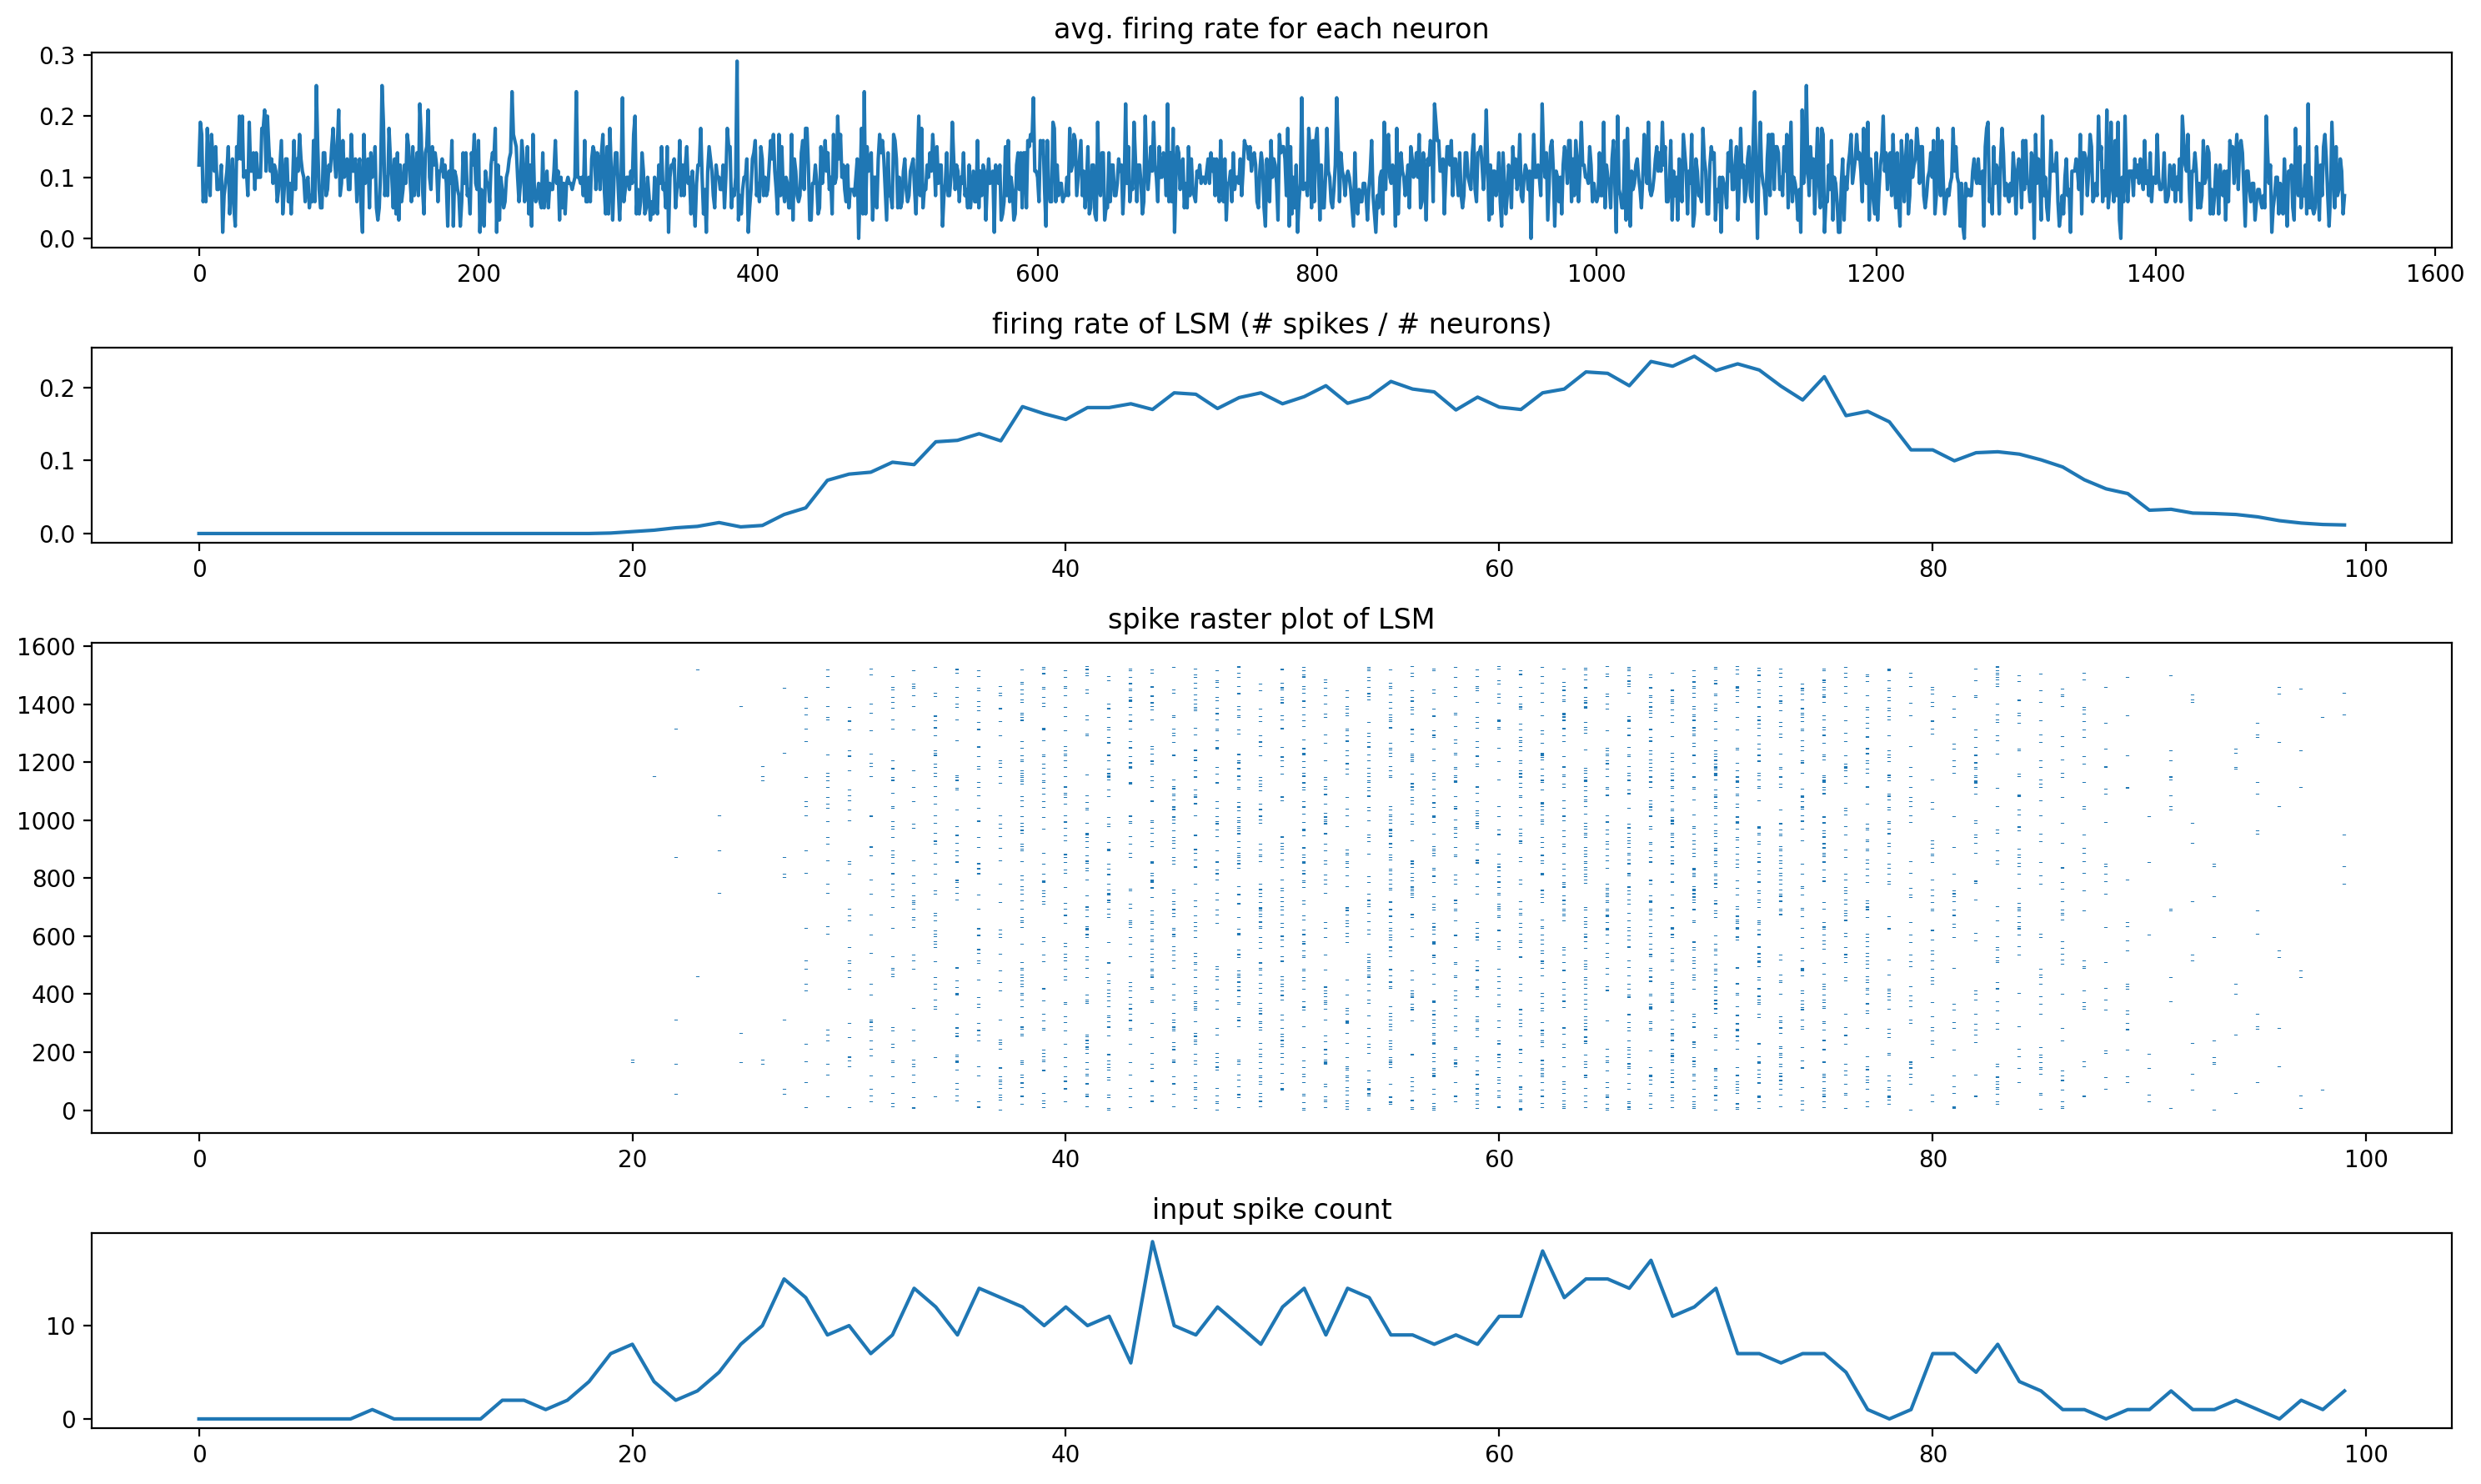

In [109]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15, 9), dpi=200)

gs = fig.add_gridspec(5, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2:4, :])
ax4 = fig.add_subplot(gs[4, :], sharex=ax3)

ax1.set_title('avg. firing rate for each neuron')
ax1.plot(lsm_spikes.mean(axis=1))
ax2.set_title('firing rate of LSM (# spikes / # neurons)')
ax2.plot(lsm_spikes.mean(axis=0))
ax3.set_title('spike raster plot of LSM')
for i in range(ds[0][0].shape[0]):
    ax3.eventplot(np.where(lsm_spikes[i] == 1), lineoffsets=i, linelengths=0.75)
ax4.set_title('input spike count')
ax4.plot(ds[0][0].sum(axis=0))
plt.tight_layout()

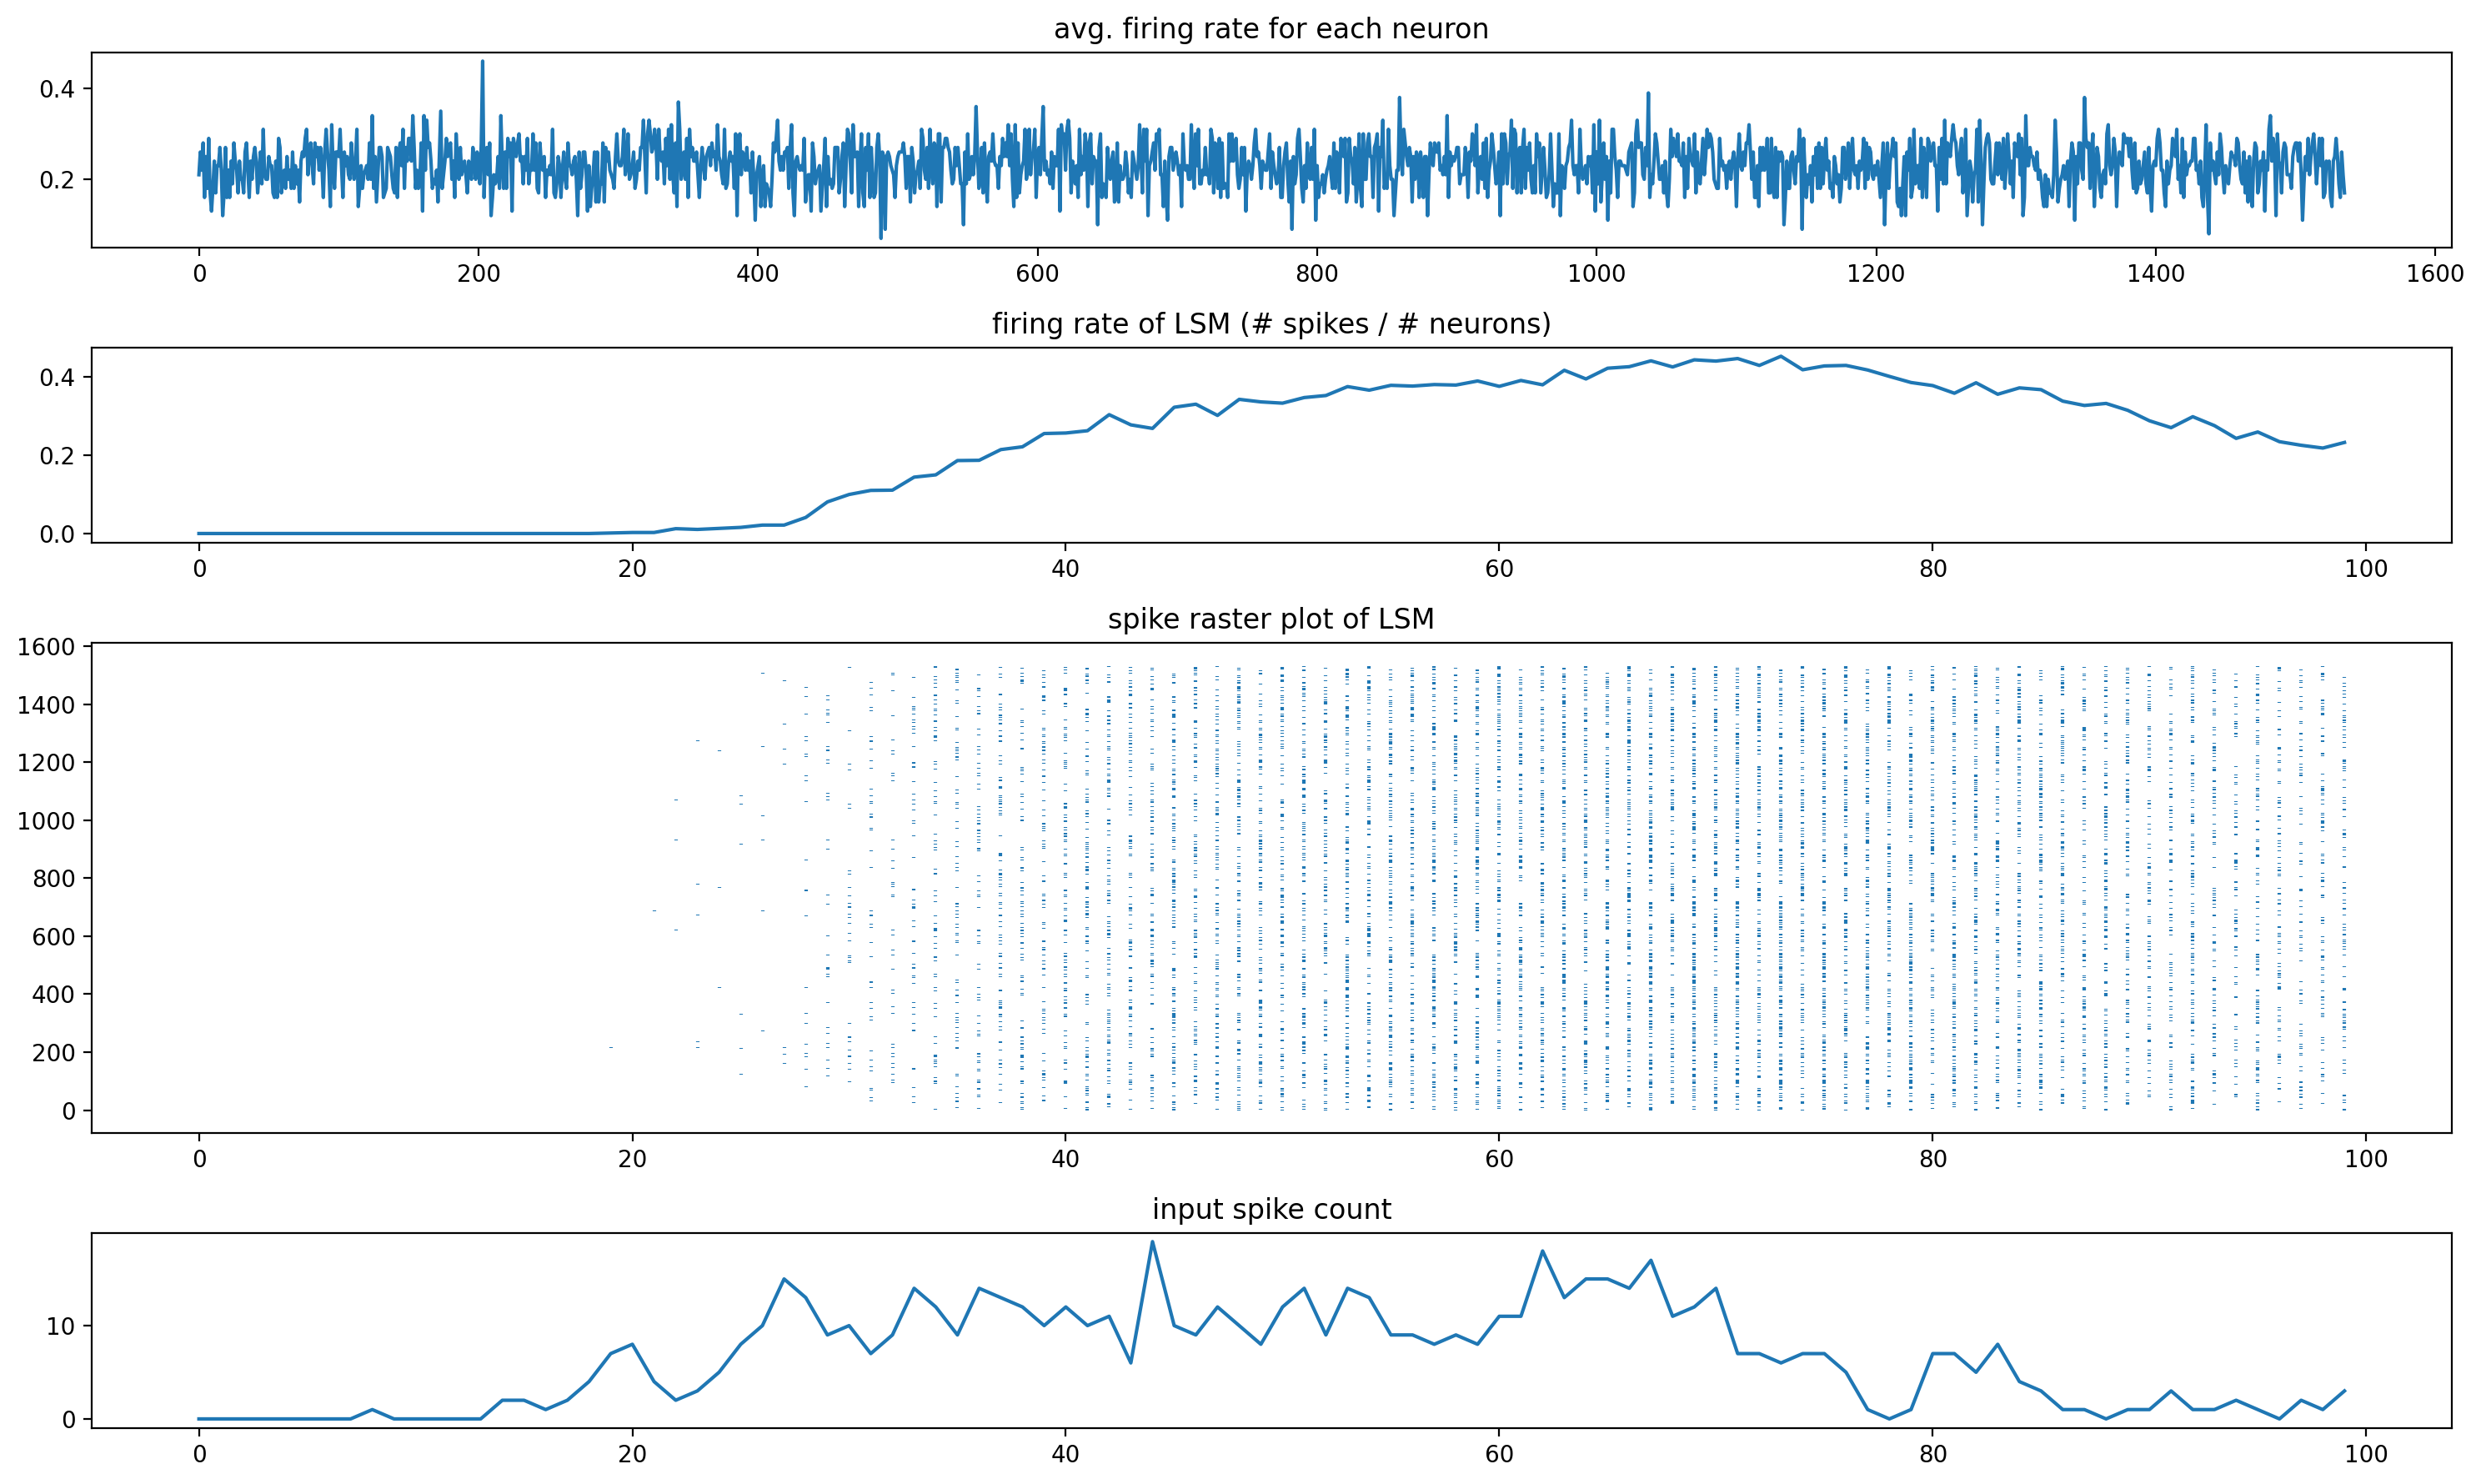

In [107]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15, 9), dpi=200)

gs = fig.add_gridspec(5, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2:4, :])
ax4 = fig.add_subplot(gs[4, :], sharex=ax3)

ax1.set_title('avg. firing rate for each neuron')
ax1.plot(lsm_spikes.mean(axis=1))
ax2.set_title('firing rate of LSM (# spikes / # neurons)')
ax2.plot(lsm_spikes.mean(axis=0))
ax3.set_title('spike raster plot of LSM')
for i in range(ds[0][0].shape[0]):
    ax3.eventplot(np.where(lsm_spikes[i] == 1), lineoffsets=i, linelengths=0.75)
ax4.set_title('input spike count')
ax4.plot(ds[0][0].sum(axis=0))
plt.tight_layout()

## Basic LIF LSM

In [1]:
import numpy as np
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

n_neurons = 20
w_in = np.random.rand(n_neurons, 1) * 1.2
w_in[np.random.rand(n_neurons, 1) < 0.5] = 0.
w = np.random.rand(n_neurons, n_neurons) * 0.5
w[np.random.rand(n_neurons, n_neurons) < 0.75] = 0.

n_neurons = 2
w_in = np.array([[0,1]]).reshape(-1,1)
w = np.array([[0,1], [1,0]])

lif_input = LIF(shape=(1,), vth=10., dv=0.1, du=0.1, bias_mant=1.1)
lsm = LIF(shape=(n_neurons,), vth=5., dv=0.1, du=0.1, bias_mant=0.)
inp_dense = Dense(weights=w_in)
rec_dense = Dense(weights=w)
lif_input.s_out.connect(inp_dense.s_in)
inp_dense.a_out.connect(lsm.a_in)
lsm.s_out.connect(rec_dense.s_in)
rec_dense.a_out.connect(lsm.a_in)

monitor_inp = Monitor()
monitor_lsm = Monitor()
num_steps = 100

monitor_inp.probe(lif_input.v, num_steps)
monitor_lsm.probe(lsm.v, num_steps)


run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="floating_pt")
lsm.run(condition=run_condition, run_cfg=run_cfg)

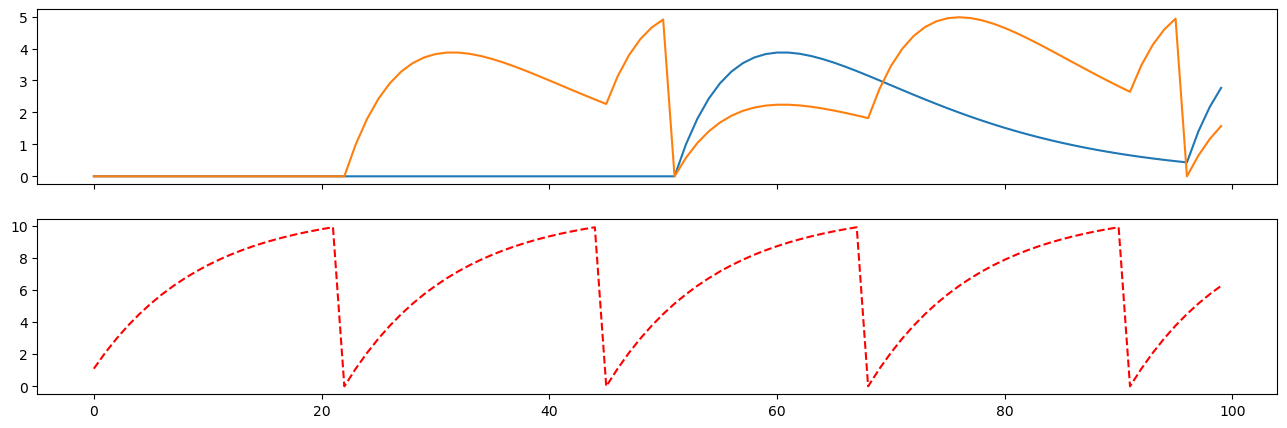

In [2]:
from matplotlib import pyplot as plt

data_inp = monitor_inp.get_data()
data_lsm = monitor_lsm.get_data()

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16, 5))
# ax0 = fig.add_subplot(111)
ax[1].plot(data_inp[list(data_inp.keys())[0]]['v'], c='red', ls='--')
# monitor_lsm.plot(ax1, lsm.v)
ax[0].plot(data_lsm[list(data_lsm.keys())[0]]['v']);

## tests with simple LIFs

In [1]:
import numpy as np
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

lif = LIF(shape=(1,), vth=10., dv=0.1, du=0.1, bias_mant=1.1)
dense = Dense(weights=np.eye(1)*1.)
lif.s_out.connect(dense.s_in)
# dense.a_out.connect(lif.a_in)

monitor_lif = Monitor()
num_steps = 100

monitor_lif.probe(lif.v, num_steps)


run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="floating_pt")
lif.run(condition=run_condition, run_cfg=run_cfg)

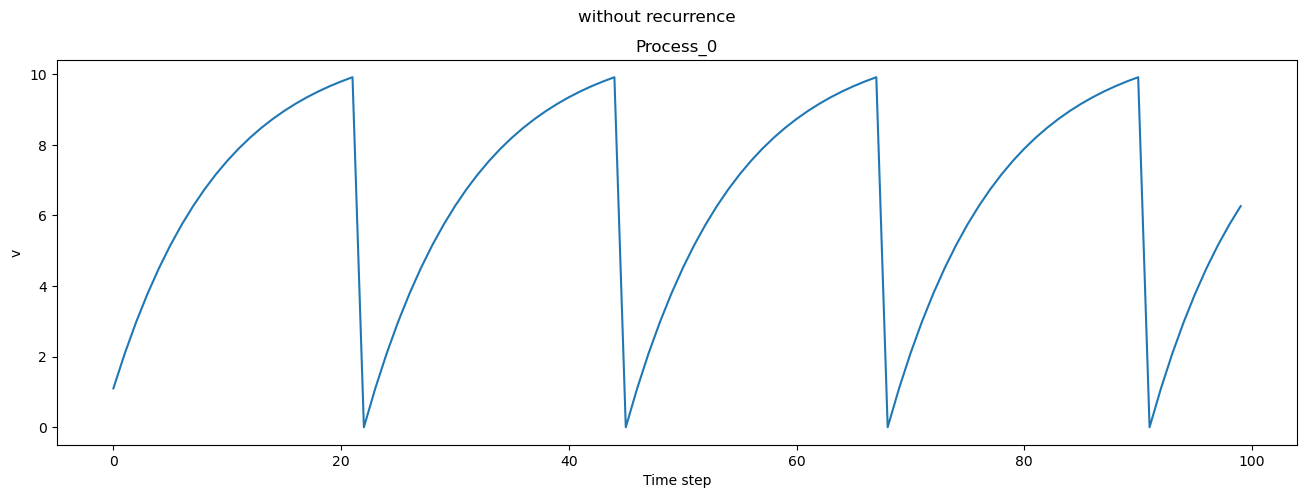

In [2]:
from matplotlib import pyplot as plt
data_lif = monitor_lif.get_data()
fig = plt.figure(figsize=(16, 5))
fig.suptitle('without recurrence')
ax0 = fig.add_subplot(111)
monitor_lif.plot(ax0, lif.v)

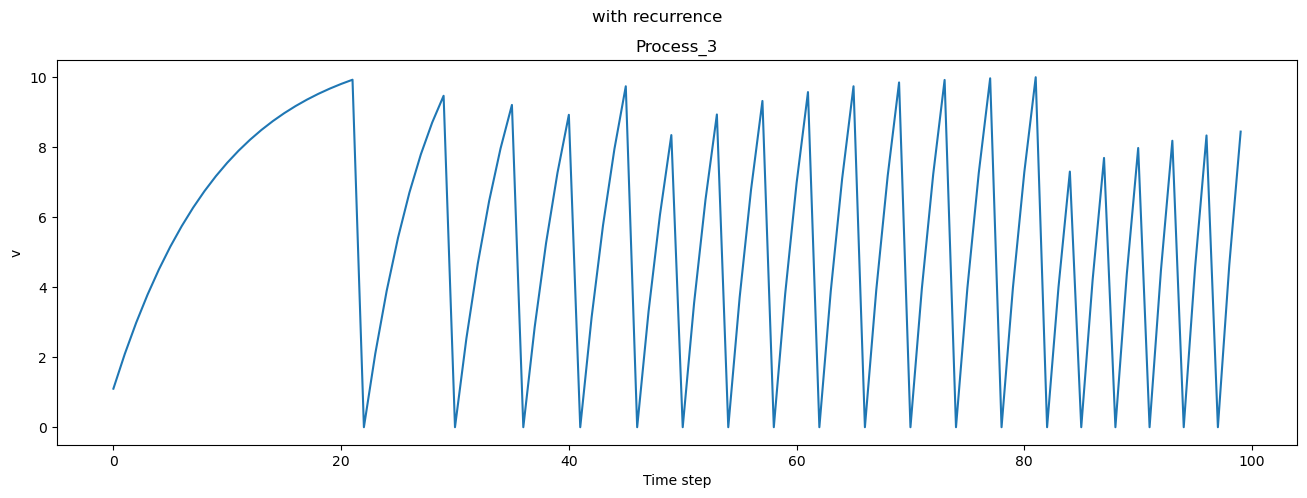

In [5]:
from matplotlib import pyplot as plt
data_lif = monitor_lif.get_data()
fig = plt.figure(figsize=(16, 5))
fig.suptitle('with recurrence')
ax0 = fig.add_subplot(111)
monitor_lif.plot(ax0, lif.v)

In [4]:
import numpy as np
lif1 = LIF(shape=(1, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=(1.1, 1.2, 1.3),           # Bias added to the membrane voltage in every timestep
           name="lif1")

dense = Dense(weights=np.random.rand(2, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif2 = LIF(shape=(2, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name='lif2')

# Connect the OutPort of lif1 to the InPort of dense
lif1.s_out.connect(dense.s_in)

# Connect the OutPort of dense to the InPort of lif2
dense.a_out.connect(lif2.a_in)

from lava.proc.monitor.process import Monitor

monitor_lif1 = Monitor()
monitor_lif2 = Monitor()

num_steps = 100

monitor_lif1.probe(lif1.v, num_steps)
monitor_lif2.probe(lif2.v, num_steps)

from lava.magma.core.run_conditions import RunSteps, RunContinuous

run_condition = RunSteps(num_steps=num_steps)

from lava.magma.core.run_configs import Loihi2SimCfg

run_cfg = Loihi2SimCfg(select_tag="floating_pt")
lif2.run(condition=run_condition, run_cfg=run_cfg)

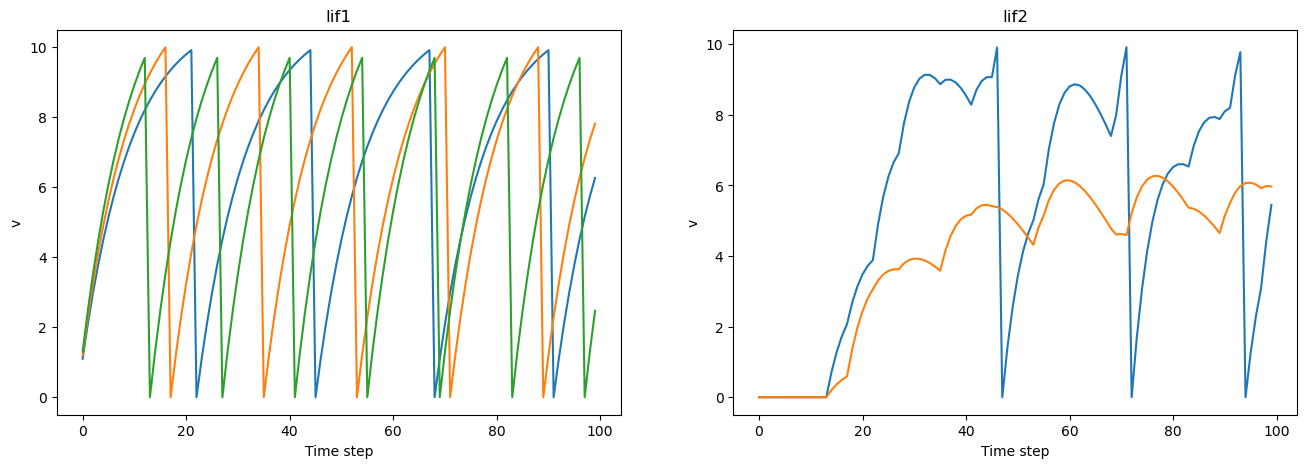

In [5]:
data_lif1 = monitor_lif1.get_data()
data_lif2 = monitor_lif2.get_data()

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the recorded data
monitor_lif1.plot(ax0, lif1.v)
monitor_lif2.plot(ax1, lif2.v)